In [365]:
!pip install nltk

zsh:1: command not found: pip


In [366]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer


In [367]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [368]:
raw_data = []

In [369]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    label = convert_label(data_line[1])
    statement = data_line[2]
    return (label, statement)

In [370]:
load_data('fake_news.tsv')


In [371]:

# Input: a string of one statement
url_regex = re.compile(r"(https?:\/\/)?(www\.)?[a-z0-9-]+\.(com|org|net|edu|gov|mil|uk|co|arpa|info|eu|us|site)(\.[a-z]{2,3})?") 
tokenise_regex = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    pre_processed_text = re.compile(r"#\w+").sub("[hashtag]", text)
    pre_processed_text = re.compile(r"@\w+").sub("[mention]", pre_processed_text)
    pre_processed_text = url_regex.sub("[url]", pre_processed_text)
    pre_processed_text = re.compile(r"[.;:!\'?,\"()\[\]]").sub("", pre_processed_text)
#     lemmatizer=WordNetLemmatizer()
#     input_str=word_tokenize(text)
#     for word in input_str:
#         print(lemmatizer.lemmatize(word))
    pre_processed_text = tokenise_regex.findall(pre_processed_text.lower())
    return pre_processed_text

# Question 2: Basic Feature Extraction (20 marks)

In [372]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    local_feature_dict = {}
    
    for token in tokens:
        if token in local_feature_dict:
            local_feature_dict[token] += 1
        else:
            local_feature_dict[token] = 1
        if token in global_feature_dict:
            global_feature_dict[token] += 1
        else:
            global_feature_dict[token] = 1 
# ## By using Bag of words model using CountVectorizer
#     count_vect = CountVectorizer(stop_words='english')
#     X_train_counts = count_vect.fit(tokens)
#     print(len(count_vect.get_feature_names()))
#     for feature in count_vect.get_feature_names():
#         print(count_vect.get_feature_names())
#         local_feature_dict[feature] = len(count_vect.get_feature_names())
# ## By using TFID
#     tfidf_vec = TfidTransformer()
#     traindata_tfidf_vec = tfidf_vec.fit_transform(count_vect.get_feature_names())
#     print(traindata_tfidf_vec)
#     print(local_feature_dict)
    #feature_names = count_vect.get_feature_names()
    #result = list(map(lambda row:dict(zip(feature_names,row)), X_train_counts.toarray()))
    #print(result)
    #print(len(feature_names))
    return local_feature_dict

In [373]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    print("train data", len(data))
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [374]:
#solution
from sklearn.metrics import classification_report


def cross_validate(dataset, folds):
    
    results = []
    fold_size = int(len(dataset)/folds) + 1
    sum_real_precision, sum_fake_precision, sum_real_recall, sum_fake_recall, sum_real_f1_score, sum_fake_f1_score, sum_real_support, sum_fake_support, sum_accuracy = 0, 0, 0, 0, 0, 0, 0, 0, 0
    print("Fold size", fold_size)
    print("lenght of data set", len(dataset))
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        
        # FILL IN THE METHOD HERE
        print("\n")
        fold_span = i+fold_size
        print("Fold start on items %d - %d" % (i, fold_span))
        print("dataset range:", len(dataset[:i]), len(dataset[fold_span:]))
        #print("train data length", len(dataset[:i] + dataset[fold_span:]))
        # creating a subset of dataset for testing
        test_data = []
        test_true_prediction = []
        #print("dataset value at 0", dataset[0])
        for data in dataset[i:fold_span]:
            test_data.append(data[0])
            test_true_prediction.append(data[1])
        print("Test Data is ", len(test_data))
        print("Test Data prediction is ", len(test_true_prediction))
        # training the model with subset of train data
        train = train_classifier(dataset[:i] + dataset[fold_span:])
        #print("train:", train)
        # getting predcitions based on test and train subsets
        prediction = predict_labels(test_data, train)
#         print(metrics.classification_report(test_true_prediction, prediction, output_dict=True))
        class_report = classification_report(test_true_prediction, prediction, output_dict=True)
        
        sum_real_precision += class_report['REAL']['precision']
        sum_fake_precision += class_report['FAKE']['precision']
        sum_real_recall += class_report['REAL']['recall']
        sum_fake_recall += class_report['FAKE']['recall']
        sum_real_f1_score += class_report['REAL']['f1-score']
        sum_fake_f1_score += class_report['FAKE']['f1-score']
        sum_real_support += class_report['REAL']['support']
        sum_fake_support += class_report['FAKE']['support']
        sum_accuracy += class_report['accuracy']
        

        
    return {"REAL": {"precision":sum_real_precision/folds, "recall":sum_real_recall/folds, "f1-score":sum_real_f1_score/folds, "support": sum_real_support/folds},
                "FAKE": {"precision":sum_fake_precision/folds, "recall":sum_fake_recall/folds, "f1-score":sum_fake_f1_score/folds, "support": sum_fake_support/folds}, "accuracy":sum_accuracy/folds}
    

In [375]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [376]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 
#print(raw_data)
# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
13448


In [377]:
train_data

[({'says': 1,
   'the': 1,
   'annies': 1,
   'list': 1,
   'political': 1,
   'group': 1,
   'supports': 1,
   'third-trimester': 1,
   'abortions': 1,
   'on': 1,
   'demand': 1},
  'FAKE'),
 ({'when': 2,
   'did': 1,
   'the': 1,
   'decline': 1,
   'of': 1,
   'coal': 1,
   'start': 1,
   'it': 1,
   'started': 2,
   'natural': 1,
   'gas': 1,
   'took': 1,
   'off': 1,
   'that': 1,
   'to': 1,
   'begin': 1,
   'in': 1,
   'president': 1,
   'george': 1,
   'w': 1,
   'bushs': 1,
   'administration': 1},
  'REAL'),
 ({'hillary': 1,
   'clinton': 1,
   'agrees': 1,
   'with': 1,
   'john': 1,
   'mccain': 1,
   'by': 1,
   'voting': 1,
   'to': 1,
   'give': 1,
   'george': 1,
   'bush': 1,
   'the': 2,
   'benefit': 1,
   'of': 1,
   'doubt': 1,
   'on': 1,
   'iran': 1},
  'REAL'),
 ({'health': 1,
   'care': 1,
   'reform': 1,
   'legislation': 1,
   'is': 1,
   'likely': 1,
   'to': 1,
   'mandate': 1,
   'free': 1,
   'sex': 1,
   'change': 1,
   'surgeries': 1},
  'FAKE'),
 (

In [378]:
cv = cross_validate(train_data, 10)# will work and output overall performance of p, r, f-score when cv implemented
cv

Fold size 820
lenght of data set 8192


Fold start on items 0 - 820
dataset range: 0 7372
Test Data is  820
Test Data prediction is  820
Training Classifier...
train data 7372


Fold start on items 820 - 1640
dataset range: 820 6552
Test Data is  820
Test Data prediction is  820
Training Classifier...
train data 7372


Fold start on items 1640 - 2460
dataset range: 1640 5732
Test Data is  820
Test Data prediction is  820
Training Classifier...
train data 7372


Fold start on items 2460 - 3280
dataset range: 2460 4912
Test Data is  820
Test Data prediction is  820
Training Classifier...
train data 7372


Fold start on items 3280 - 4100
dataset range: 3280 4092
Test Data is  820
Test Data prediction is  820
Training Classifier...
train data 7372


Fold start on items 4100 - 4920
dataset range: 4100 3272
Test Data is  820
Test Data prediction is  820
Training Classifier...
train data 7372


Fold start on items 4920 - 5740
dataset range: 4920 2452
Test Data is  820
Test Data prediction is 

{'REAL': {'precision': 0.6160466580190249,
  'recall': 0.6125203683118914,
  'f1-score': 0.6138789760951925,
  'support': 463.0},
 'FAKE': {'precision': 0.5007642230630482,
  'recall': 0.5044916870667416,
  'f1-score': 0.5020925564041951,
  'support': 356.2},
 'accuracy': 0.5653388201369698}

# 4. Error Analysis (10 marks)

In [379]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Training Classifier...
train data 7372
Total Predictions made:  820
Fake Predictions:  362
Real Predictions:  458


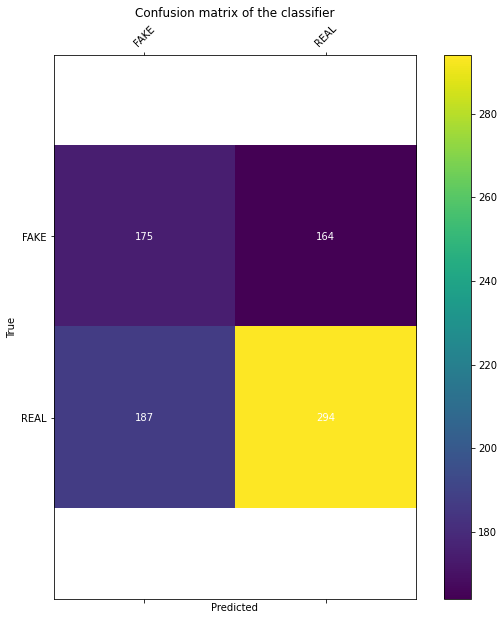

{'FAKE': {'precision': 0.48342541436464087, 'recall': 0.5162241887905604, 'f1-score': 0.49928673323823103, 'support': 339}, 'REAL': {'precision': 0.6419213973799127, 'recall': 0.6112266112266113, 'f1-score': 0.6261980830670927, 'support': 481}, 'accuracy': 0.5719512195121951, 'macro avg': {'precision': 0.5626734058722768, 'recall': 0.5637254000085858, 'f1-score': 0.5627424081526619, 'support': 820}, 'weighted avg': {'precision': 0.5763968385479894, 'recall': 0.5719512195121951, 'f1-score': 0.5737310738085755, 'support': 820}}


In [380]:
# error analysis on simple train-test split: first fold 
fold_size = 10
first_fold = round(len(train_data)/fold_size) + 1
test_subset = []
test_prediction = []
train_subset = train_classifier(train_data[first_fold:])
#print(len(train_data))
test_first_fold = train_data[:first_fold]

for data in test_first_fold:
    test_subset.append(data[0])
    test_prediction.append(data[1])

prediction = predict_labels(test_subset, train_subset)
prediction_count = {}

for pred in prediction:
    prediction_count[pred] = prediction.count(pred)
print("Total Predictions made: ", len(prediction))
print("Fake Predictions: ", prediction_count['FAKE'])
print("Real Predictions: ", prediction_count['REAL'])
confusion_matrix_heatmap(test_prediction, prediction, ("FAKE", "REAL"))
error_class_report = classification_report(test_prediction, prediction, output_dict=True)
print(error_class_report)        

In [381]:
dataset_len=len(train_data)
fold_size = 10
fold_span = round(dataset_len/fold_size)+1
test_raw = raw_data[:fold_span]
fieldnames = ['Statements', 'True_Results', 'Predicted_Results', "Error"]
error_report = {}
itr = 0
i=0
test_predictions = []
no_false_positive = 0
no_false_negative = 0
no_actual_positive = 0
no_actual_negative = 0
for data in test_raw:
    error_type = ""
    if data[1] != prediction[itr]:
        if data[1] == "FAKE":
            error_type = "False Positive"
            no_false_positive = no_false_positive + 1
        else:
            error_type = "False Negative"
            no_false_negative = no_false_negative + 1
        error_report = {"Statements": data[0], "True_Results":data[1], "Predicted_Results":prediction[itr], "Error": error_type }
        test_predictions.append(error_report)
    else:
        if data[1] == "REAL":
            no_actual_positive = no_actual_positive + 1
        else:
            no_actual_negative = no_actual_negative + 1
    itr = itr + 1
with open('error_analysis_report.csv', 'w') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(test_predictions)

for result in test_predictions[:5]:
    print(result)
    print("\n")

print("Number of false negative predictions: ", no_false_negative)
print("Number of false positive predictions: ", no_false_positive)
print("Classification Accuracy is ", (len(prediction)-(no_false_negative + no_false_positive))/len(prediction))
print("Error Rate: ", ((no_false_negative + no_false_positive))/len(prediction))
print("Number of Actual Positives", no_actual_positive)
print("Number of Actual Negatives", no_actual_negative)
print("Sensitivity: ", (no_actual_positive)/(no_actual_positive + no_false_positive))
print("Specificity: ", (no_actual_negative)/(no_actual_negative + no_false_negative))

{'Statements': 'Health care reform legislation is likely to mandate free sex change surgeries.', 'True_Results': 'FAKE', 'Predicted_Results': 'REAL', 'Error': 'False Positive'}


{'Statements': 'Jim Dunnam has not lived in the district he represents for years now.', 'True_Results': 'FAKE', 'Predicted_Results': 'REAL', 'Error': 'False Positive'}


{'Statements': "I'm the only person on this stage who has worked actively just last year passing, along with Russ Feingold, some of the toughest ethics reform since Watergate.", 'True_Results': 'REAL', 'Predicted_Results': 'FAKE', 'Error': 'False Negative'}


{'Statements': 'Says GOP primary opponents Glenn Grothman and Joe Leibham cast a compromise vote that cost $788 million in higher electricity costs.', 'True_Results': 'REAL', 'Predicted_Results': 'FAKE', 'Error': 'False Negative'}


{'Statements': 'When Mitt Romney was governor of Massachusetts, we didnt just slow the rate of growth of our government, we actually cut it.', 'True_Results':

# Questions 5 (20%) and 6 (20%) (recommend starting a new notebook)

In [382]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'the': 2, 'bush': 1, 'tax': 1, 'cuts': 1, 'helped': 1, 'to': 1, 'create': 1, 'a': 1, 'substantial': 1, 'part': 1, 'of': 1, 'deficit': 1}, 'REAL')
Training Classifier...
train data 8192
Done training!
Precision: 0.550641
Recall: 0.550512
F Score:0.550575
